# Advanced scikit-learn

```
Authors: Alexandre Gramfort
         Thomas Moreau
```

The aim of this notebook is:

  - to explain the **full scikit-learn API** (estimators, transformers, classifiers, regressors, splitters)
  - to explain how to assemble these objects in complex **pipelines with mixed data types** (numerical, categorical etc.) using **Pipeline** and **ColumnTransformer objects**.
  - have you **write your own transformer, splitter and classifier**.

To explain these concepts we will start from a full working code based on the Titanic dataset. Then we will deconstruct all the blocks and start writing our own Python classes.


First, let's fetch the "titanic" dataset directly from OpenML.

In [2]:
import pandas as pd
from sklearn.datasets import fetch_openml

In [3]:
X_df, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X_df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
X_df.shape

(1309, 13)

The classification task is to predict whether or not a person will survive the Titanic disaster.

We will split the data into a training and a testing set.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y, random_state=42)

<div class="alert alert-success">
    <p><b>QUESTIONS</b>:</p>
    <ul>
        <li>What would happen if you try to fit a <tt>RandomForestClassifier</tt>?</li>
    </ul>
</div>

In [10]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)

# Working only with numerical data

Let's start with a model using only numerical columns.

In [11]:
X_df.dtypes

pclass        float64
name           object
sex          category
age           float64
sibsp         float64
parch         float64
ticket         object
fare          float64
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

## Pandas preprocessing

Before using scikit-learn, we will do some simple preprocessing using pandas. First, let's select only a few the numerical columns:

In [12]:
num_cols = ['pclass', 'age', 'parch', 'fare']

X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

<div class="alert alert-success">
    <p><b>QUESTIONS</b>:</p>
    <ul>
        <li>What would happen if you try to fit a <tt>RandomForestClassifier</tt>?</li>
    </ul>
</div>

In [18]:
model = RandomForestClassifier(n_estimators=100)

We might want to look into a summary of the data that we try to fit.

In [19]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 1139 to 1126
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  981 non-null    float64
 1   age     784 non-null    float64
 2   parch   981 non-null    float64
 3   fare    980 non-null    float64
dtypes: float64(4)
memory usage: 38.3 KB


Since there are some missing data, we can replace them with a mean.

In [20]:
X_train_num_imputed = X_train_num.fillna(X_train_num.mean())
X_train_num_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 1139 to 1126
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  981 non-null    float64
 1   age     981 non-null    float64
 2   parch   981 non-null    float64
 3   fare    981 non-null    float64
dtypes: float64(4)
memory usage: 38.3 KB


In [26]:
model.fit(X_train_num_imputed, y_train)
y_pred=model.predict(X_test_num_imputed)

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
    <li>What should we do if there are also missing values in the test set?</li>
    <li>Process the test set so as to be able to compute the test score of the model.</li>
    </ul>
</div>

Solution is in `solutions/01-pandas_fillna_test.py`

In [27]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6432926829268293


In [28]:
model.score(X_test_num_imputed, y_test)

0.6432926829268293

## Make it less error prone using scikit-learn

Scikit-learn provides some "transformers" to preprocess the data. `sklearn.impute.SimpleImputer` is a transformer allowing for the same job than the processing done with Pandas. However, we will see later that it integrates greatly with other scikit-learn components.

In [29]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")

As any estimator in scikit-learn, a transformer has a `fit` method which should be called on the training data to learn the required statistics. In the case of a mean imputer, we need to compute the mean for each feature.

In [30]:
imputer.fit(X_train_num)

SimpleImputer()

In [31]:
imputer.statistics_

array([ 2.29867482, 29.34768278,  0.39143731, 33.68646633])

To impute the values by the mean, we can use the `transform` method.

In [33]:
imputer.transform(X_train_num)

array([[ 3.    , 38.    ,  0.    ,  7.8958],
       [ 3.    ,  6.    ,  1.    , 15.2458],
       [ 1.    , 52.    ,  1.    , 79.65  ],
       ...,
       [ 3.    , 28.5   ,  0.    , 16.1   ],
       [ 3.    , 26.    ,  0.    ,  7.925 ],
       [ 3.    , 28.    ,  0.    ,  7.8958]])

As previoulsy mentioned, we should impute with the values computed in `fit` when imputing the test set.

<div class="alert alert-warning">
<b>What is a "Transformer"?</b>: <br/>

A scikit-learn transform should implement at least these methods:

<ul>
    <li>fit(X, y=None)</li>
    <li>transform(X)</li>
    <li>get_params()</li>
    <li>set_params(**kwargs)</li>  
</ul>
</div>

In [34]:
params = imputer.get_params()
params

{'add_indicator': False,
 'copy': True,
 'fill_value': None,
 'missing_values': nan,
 'strategy': 'mean',
 'verbose': 0}

In [35]:
imputer.fit?

In [ ]:
imputer.transform?

Let's look at the attributes of our `imputer`

In [36]:
public_attributes = [attr for attr in dir(imputer) if not attr.startswith('_')]
public_attributes

['add_indicator',
 'copy',
 'fill_value',
 'fit',
 'fit_transform',
 'get_params',
 'indicator_',
 'inverse_transform',
 'missing_values',
 'n_features_in_',
 'set_params',
 'statistics_',
 'strategy',
 'transform',
 'verbose']

We have among these attributes:

- **parameters** (keys in get_params method output)
- **methods** (fit, transform, etc.)
- **estimated quantities** that appear after a `fit` (ending with `_`)

In [37]:
public_methods = [
    attr for attr in dir(imputer)
    if not attr.startswith('_') and
    not attr.endswith('_') and
    attr not in params]
public_methods

['fit',
 'fit_transform',
 'get_params',
 'inverse_transform',
 'set_params',
 'transform']

In [38]:
imputer.inverse_transform?

Estimated quantities:

In [39]:
fit_attributes = [
    attr for attr in dir(imputer)
    if not attr.startswith('_') and
    attr.endswith('_')]
fit_attributes

['indicator_', 'n_features_in_', 'statistics_']

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>What are the attributes of a RandomForestClassifier. You will decompose these in the 3 categories.</li>
    </ul>
</div>

In [43]:
fit_attributes = [
    attr for attr in dir(RandomForestClassifier)
    if not attr.startswith('_') and attr.endswith('_')]
fit_attributes

['feature_importances_']

### Using a Pipeline

We saw earlier that we should be careful when preprocessing data to avoid any "data leak" (i.e. reusing some knowledge from the training when testing our model). Scikit-learn provides the `Pipeline` class to make successive transformations. In addition, it will ensure that the right operations will be applied at the right time.

In [44]:
from sklearn import set_config

set_config(display='diagram')

In [46]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(SimpleImputer(strategy='mean'),
                      RandomForestClassifier(n_estimators=200))
model.fit(X_train_num, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200))])

Alternative syntax using named "steps".

In [47]:
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("imputer", SimpleImputer(strategy='mean')),
    ("classifier", RandomForestClassifier(n_estimators=200))    
])
model.fit(X_train_num, y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier', RandomForestClassifier(n_estimators=200))])

In [49]:
model.score(X_test_num, y_test)

0.6676829268292683

Saving your estimator in HTML for presentations, blog posts etc.

In [ ]:
from sklearn.utils import estimator_html_repr

with open('model.html', 'w') as fid:
    fid.write(estimator_html_repr(model))

# !open model.html

### Manipulating Pipeline steps

A pipeline is a sequence of `steps`. Each `step` is a scikit-learn estimator. All steps except the last one are typically **transformers** (fit, fit_transform, transform methods) and the last step is a **classifier** or a **regressor**.

In [50]:
model.steps  # accessing steps as a list

[('imputer', SimpleImputer()),
 ('classifier', RandomForestClassifier(n_estimators=200))]

In [51]:
model.named_steps  # accessing steps with their names as a dict

{'imputer': SimpleImputer(),
 'classifier': RandomForestClassifier(n_estimators=200)}

In [52]:
model[:1]  # slicing a pipeline

Pipeline(steps=[('imputer', SimpleImputer())])

In [53]:
model[-1]

RandomForestClassifier(n_estimators=200)

In [54]:
from sklearn.base import is_classifier

is_classifier(model[-1])

True

Let's decompose the pipeline and chain the operations manually (mimicking what the Pipeline object does internally):

In [55]:
preprocessor = model[:-1]
classifier = model[-1]

X_train_preproc = preprocessor.fit_transform(X_train_num, y_train)
X_test_preproc = preprocessor.transform(X_test_num)

classifier.fit(X_train_preproc, y_train)
classifier.score(X_test_preproc, y_test)

0.6737804878048781

### Towards a ColumnTransformer

If we want to directly fit the model on `X_train`, we can select the numerical columns using  a `ColumnTransformer` object:

In [56]:
from sklearn.compose import ColumnTransformer

ColumnTransformer?

In [57]:
numerical_preprocessing = ColumnTransformer([
    ("imputer", SimpleImputer(strategy='mean'), num_cols)
])
    
model = Pipeline([
    ("numerical preproc.", numerical_preprocessing),
    ("classifier", RandomForestClassifier(n_estimators=100)),
])

model.fit(X_train, y_train)

Pipeline(steps=[('numerical preproc.',
                 ColumnTransformer(transformers=[('imputer', SimpleImputer(),
                                                  ['pclass', 'age', 'parch',
                                                   'fare'])])),
                ('classifier', RandomForestClassifier())])

In [58]:
model.score(X_test, y_test)

0.6676829268292683

# Working only with categorical data

Categorical columns (even more string data types) are not supported natively by machine-learning algorithms and required some preprocessing step usually called encoding. The most classical categorical encoders are the `OrdinalEncoder` and the `OneHotEncoder`. Let's first see the `OrdinalEncoder`.

In [59]:
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1139,3.0,"Rekic, Mr. Tido",male,38.0,0.0,0.0,349249,7.8958,None,S,None,NaN,None
678,3.0,"Boulos, Master. Akar",male,6.0,1.0,1.0,2678,15.2458,None,C,None,NaN,"Syria Kent, ON"
290,1.0,"Taussig, Mr. Emil",male,52.0,1.0,1.0,110413,79.6500,E67,S,None,NaN,"New York, NY"
285,1.0,"Straus, Mr. Isidor",male,67.0,1.0,0.0,PC 17483,221.7792,C55 C57,S,None,96.0,"New York, NY"
1157,3.0,"Rosblom, Mr. Viktor Richard",male,18.0,1.0,1.0,370129,20.2125,None,S,None,NaN,None


In [60]:
cat_cols = ['sex', 'embarked', 'pclass']

In [61]:
X_train_cat = X_train[cat_cols]

In [62]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 1139 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sex       981 non-null    category
 1   embarked  980 non-null    category
 2   pclass    981 non-null    float64 
dtypes: category(2), float64(1)
memory usage: 17.5 KB


In [63]:
from sklearn.preprocessing import OrdinalEncoder

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
    ("ordinal_encoder", OrdinalEncoder())
])

categorical_preprocessing = ColumnTransformer([
    ("categorical_preproc", cat_pipeline, cat_cols)
])

model = Pipeline([
    ("categorical_preproc", categorical_preprocessing),
    ("classifier", RandomForestClassifier(n_estimators=100))
])
model.fit(X_train, y_train)

Pipeline(steps=[('categorical_preproc',
                 ColumnTransformer(transformers=[('categorical_preproc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'embarked',
                                                   'pclass'])])),
                ('classifier', RandomForestClassifier())])

In [64]:
model.score(X_test, y_test)

0.7713414634146342

### Accessing and updating parameters of a Pipeline

Pipeline is yet another scikit-learn estimators. It therefore has the methods `set_params` and `get_params`

In [65]:
model.get_params()

{'memory': None,
 'steps': [('categorical_preproc',
   ColumnTransformer(transformers=[('categorical_preproc',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('ordinal_encoder',
                                                     OrdinalEncoder())]),
                                    ['sex', 'embarked', 'pclass'])])),
  ('classifier', RandomForestClassifier())],
 'verbose': False,
 'categorical_preproc': ColumnTransformer(transformers=[('categorical_preproc',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(fill_value='missing',
                                                                 strategy='constant')),
                                                

In [66]:
model.set_params(classifier__n_estimators=666)
model.get_params()

{'memory': None,
 'steps': [('categorical_preproc',
   ColumnTransformer(transformers=[('categorical_preproc',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('ordinal_encoder',
                                                     OrdinalEncoder())]),
                                    ['sex', 'embarked', 'pclass'])])),
  ('classifier', RandomForestClassifier(n_estimators=666))],
 'verbose': False,
 'categorical_preproc': ColumnTransformer(transformers=[('categorical_preproc',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(fill_value='missing',
                                                                 strategy='constant')),
                                

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    There are many other types of ways to encode categorical variables.
    <ul>
        <li>Write your own categorical encoder CountEncoder. The idea is to replace categorical variables with their count in the train set.</li>
        <li>Change the ordinal encoder in the pipeline above with an instance of your CountEncoder.</li>
    </ul>
</div>

Your class will need to inherit from `BaseEstimator`, `TransformerMixin` in `sklearn.base` submodule.
You will use the class `Counter` from the collections module in the standard library.

You will your code on this toy example

```python
>>> X = np.array([
...    [0, 2],
...    [1, 3],
...    [1, 1],
...    [1, 1],
... ])
>>> ce = CountEncoder()
>>> print(ce.fit_transform(X))
[[1 1]
 [3 1]
 [3 2]
 [3 2]]
```

Solution is in `solutions/01-count_encoder.py`.

# Combining both categorical and numerical data in the pipeline

<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
    <li>Try to combine the numerical and categorical pipelines into a single <tt>ColumnTransformer</tt></li>
        <li>Fit a <tt>RandomForestClassifier</tt> on the output of this feature engineering. How does the test score evolve?</li>
    </ul>
</div>

Solution is in `solutions/01b-full_column_transformer.py`

In [68]:

from sklearn.preprocessing import OrdinalEncoder

cat_cols = ['sex', 'embarked', 'pclass']
num_cols = ['pclass', 'age', 'parch', 'fare']

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='constant', fill_value='missing')),
    ("ordinal_encoder", OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ("categorical_preproc", cat_pipeline, cat_cols),
    ("numerical_preproc", SimpleImputer(), num_cols)

])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(max_depth=10, n_estimators=500))
])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_preproc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'embarked',
                                                   'pclass']),
                                                 ('numerical_preproc',
                                                  SimpleImputer(),
                                                  ['pclass', 'age', 'parch',
                                                   'fare'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=500))])

In [69]:
model.score(X_test, y_test)

0.8079268292682927

# From one split to cross-validation (CV): splitters!

CV objects are parametrized to split data in multiple train/test splits.

A splitter should implement a `split` method.

Given a `model`, some data `X, y` and a splitter one can fit and score on
all requested data splits. Functions to do this are `cross_val_score`
(historical way) and `cross_validate` (more modern way).

Let's first define a model:

In [70]:
from sklearn.preprocessing import OrdinalEncoder

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal_encoder", OrdinalEncoder())
])

categorical_preprocessing = ColumnTransformer([
    ("categorical_preproc", cat_pipeline, cat_cols)
])

model = Pipeline([
    ("categorical_preproc", categorical_preprocessing),
    ("classifier", RandomForestClassifier(n_estimators=100))
])
model

Pipeline(steps=[('categorical_preproc',
                 ColumnTransformer(transformers=[('categorical_preproc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['sex', 'embarked',
                                                   'pclass'])])),
                ('classifier', RandomForestClassifier())])

Let's now use a default 5-fold CV. You will see that there is a large amount of discrepancy among the test_score values

In [71]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X_df, y, cv=5)
pd.DataFrame(cv_results)

,fit_time,score_time,test_score
0,0.135946,0.007995,0.515267
1,0.119912,0.008001,0.801527
2,0.119915,0.007995,0.854962
3,0.119936,0.015974,0.706107
4,0.111926,0.015988,0.616858


In [72]:
pd.DataFrame(cv_results).agg(['mean', 'std'])

,fit_time,score_time,test_score
mean,0.121527,0.011191,0.698944
std,0.008772,0.004373,0.137287


The reason is that default CV object (here 5-fold CV) is deterministic, while the distribution of "survivor" is not uniform in the dataset. See:

<AxesSubplot:>

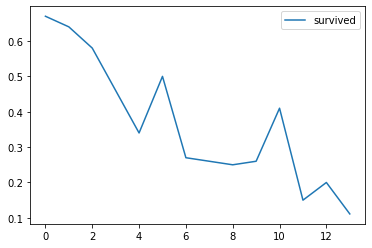

In [74]:
y.astype(int).to_frame().groupby(y.index.values // 100).mean().plot()

To fix this one needs stratified folds (so that the fraction of "survivors" is the same in each fold) but also to shuffle the data.

In [75]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(model, X_df, y, cv=cv)
pd.DataFrame(cv_results)

,fit_time,score_time,test_score
0,0.143937,0.008149,0.774809
1,0.111957,0.015990,0.824427
2,0.111925,0.015990,0.782443
3,0.111925,0.015990,0.824427
4,0.111924,0.007996,0.796935


In [76]:
pd.DataFrame(cv_results).agg(['mean', 'std'])

,fit_time,score_time,test_score
mean,0.118334,0.012823,0.800608
std,0.014313,0.004337,0.023151


The variance across folds is now much smaller which is great!

Let's look at the cross-validation scheme with a pretty plot:

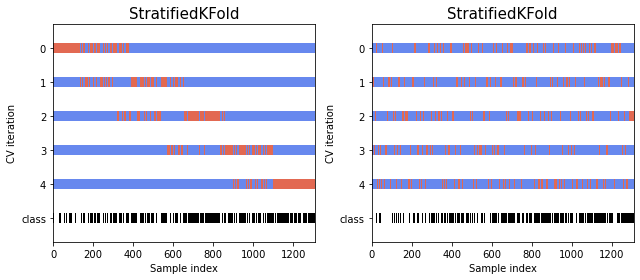

In [77]:
from plotting_utils import plot_cv_indices
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

for shuffle, ax in zip([False, True], axes):
    cv = StratifiedKFold(n_splits=5, shuffle=shuffle)
    plot_cv_indices(cv, X_df, y, ax=ax)

fig.tight_layout()

See https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html for more details and a list of the different CV objects.

### Writing your own cross-validation object

A splitter should implement the `split` and `get_n_splits` method. The `split` should return an iterable of tuples of indices and `get_n_splits` an integer corresponding to the number of splits/folds. If you know about `yield` and Python generators you can use these.

Let's first see what we get with the `cv` object above.

In [78]:
cv.get_n_splits()

5

In [79]:
for train_idx, test_idx in cv.split(X_df, y):
    print(train_idx[:5], test_idx[:5])
    print(f"N. samples train: {len(train_idx)}  -- N. samples test: {len(test_idx)}")

[1 2 3 4 6] [ 0  5 13 27 34]
N. samples train: 1047  -- N. samples test: 262
[0 1 2 3 5] [ 4  6 14 15 17]
N. samples train: 1047  -- N. samples test: 262
[0 3 4 5 6] [ 1  2  8 10 11]
N. samples train: 1047  -- N. samples test: 262
[0 1 2 4 5] [ 3 16 20 24 29]
N. samples train: 1047  -- N. samples test: 262
[0 1 2 3 4] [ 7  9 12 18 22]
N. samples train: 1048  -- N. samples test: 261


<div class="alert alert-success">
    <p><b>EXERCISE</b>:</p>
    <ul>
        <li>Imagine that the index of <code>y</code> gives you some provenance about the sample (e.g. which cohort of subjects in a clinical study). Write a splitter that allows to test the performance of a model on a left-out cohort. In other words, you will do as many splits as the number of unique values in <code>y.index.values</code>, and predict of each left-out cohort. To simulate this, we will modify the index variable <code>y</code>, just for educational purposes.
        </li>
    </ul>
</div>

Solution is in `solutions/01c-splitter.py`

In [80]:
y_with_provenance = y.copy()
y_with_provenance.index = y_with_provenance.index.values // 200  # to easily mimic 5 cohorts
n_splits = y_with_provenance.index.nunique()
print(n_splits)

7


### When you're done you can look at the assignments on scikit-learn.